## Reference data pre-training


This notebook trains and saves the reference data model on the training data

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle

from data_preparation import process_data  

from lightgbm import LGBMRegressor
import lightgbm


from IPython.display import display, HTML

Setting the seed for layer initializer

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting up the credentials for GCP

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../eng-reactor-287421-112eb767e1b3.json"

Data threading on GPU

In [4]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

Initializing the big query client

In [5]:
bq_client = bigquery.Client()

Checking if GPU is available

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Hyper-parameters for the model

The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT_RATE = 0.01
NUM_HEADS = 25
TIME2VEC_DIMENSION = 10
FF_DIM = 200

SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

### Query to fetch data from BigQuery

The SQL query uses the trade history for training data view. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds which have a rating available and the yield is a positive number less than three.  


In [8]:
DATA_QUERY = """ SELECT
  *
FROM
  `eng-reactor-287421.primary_views.trade_history_for_training`
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND sp_long IS NOT NULL
  AND sp_long != "NR"
  AND trade_date >= '2021-01-01' 
  AND trade_date <= '2021-02-01'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

### Data Preparation

We grab the data from BigQuery and convert it into a format suitable for input to the model. The process_data function uses the big query functionality to returns the data from the SQL query as a dataframe.

In [9]:
%%time
reference_data = process_data(DATA_QUERY, 
                              bq_client,
                              SEQUENCE_LENGTH,
                              NUM_FEATURES,
                              TRAIN_TEST_SPLIT,
                              'big_data.pkl')

Reading from file
File read
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negative seconds ago
Negati

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,MSRB_maturity_date,msrb_cusip,yield_spread,num_prev_messages,MSRB_INST_ORDR_DESC,...,purpose_class,purpose_sub_class,sp_long,sp_stand_alone,sp_icr_school,sp_prelim_long,sp_outlook_long,sp_watch_long,assumed_redemption_date,trade_history
0,2021060104490300,2021-06-01 13:55:02,442331XS8,103.576,0.000,2022-03-01,442331XS8,-0.885653,0,1,...,19.0,NaN,AA,None,None,None,STABLE,None,2022-03-01,"[[-68.932044405124, 5.0, 0.0, 1.0, 14.89609871..."
1,2021060100719100,2021-06-01 10:01:45,1663936U7,122.701,0.000,2029-01-01,1663936U7,-0.248653,0,1,...,37.0,51.0,AAA,None,None,None,STABLE,None,2027-01-01,"[[-73.679754241717, 2370.0, 0.0, 1.0, 16.56511..."
2,2021060105522300,2021-06-01 14:51:09,505480K77,105.347,0.002,2030-09-15,505480K77,0.254347,0,1,...,19.0,NaN,AA,A,None,None,STABLE,NM,2024-09-15,"[[4.881314511048007, 10.0, 0.0, 1.0, 16.020369..."
3,2021060103553400,2021-06-01 13:05:37,097464XQ9,112.550,0.000,2024-04-01,097464XQ9,-0.552653,0,1,...,9.0,87.0,A+,None,None,None,STABLE,None,2024-04-01,"[[-39.830910948887, 10.0, 1.0, 0.0, 12.9775179..."
4,2021060106908000,2021-06-01 16:17:38,271664DQ4,102.593,0.000,2022-05-01,271664DQ4,-0.924653,0,1,...,37.0,11.0,AA,None,A,None,NEGATIVE,None,2022-05-01,"[[-77.56528420286999, 100.0, 1.0, 0.0, 7.49164..."


CPU times: user 13min 53s, sys: 35.5 s, total: 14min 29s
Wall time: 14min 39s


We use the dictionary to map the interest payment frequency code.

In [10]:
COUPON_FREQUENCY_DICT = {0:"Unknown",
                        1:"Semiannually",
                        2:"Monthly",
                        3:"Annually",
                        4:"Weekly",
                        5:"Quarterly",
                        6:"Every 2 years",
                        7:"Every 3 years",
                        8:"Every 4 years",
                        9:"Every 5 years",
                        10:"Every 7 years",
                        11:"Every 8 years",
                        12:"Biweekly",
                        13:"Changeable",
                        14:"Daily",
                        15:"Term mode",
                        16:"Interest at maturity",
                        17:"Bimonthly",
                        18:"Every 13 weeks",
                        19:"Irregular",
                        20:"Every 28 days",
                        21:"Every 35 days",
                        22:"Every 26 weeks",
                        23:"Not Applicable",
                        24:"Tied to prime",
                        25:"One time",
                        26:"Every 10 years",
                        27:"Frequency to be determined",
                        28:"Mandatory put",
                        29:"Every 52 weeks",
                        30:"When interest adjusts-commercial paper",
                        31:"Zero coupon",
                        32:"Certain years only",
                        33:"Under certain circumstances",
                        34:"Every 15 years",
                        35:"Custom",
                        36:"Single Interest Payment"
                        }

In [11]:
df = reference_data.copy()
df.interest_payment_frequency.fillna(0, inplace=True)
df.interest_payment_frequency = df.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_DICT[x])
df.interest_payment_frequency.head()

0    Semiannually
1    Semiannually
2    Semiannually
3    Semiannually
4    Semiannually
Name: interest_payment_frequency, dtype: object

Removing trades with size less that 10,000 dollars

In [12]:
df = df[df.par_traded > 10000]
print(len(df))

1073518


In [13]:
df['quantity'] = np.log10(df.par_traded.astype(float))
df.coupon = df.coupon.astype(float)
df.issue_amount = np.log10(df.issue_amount)

Dropping a few columns that we do not use as features

In [14]:
%%time
df.drop(columns=[
                 'sp_stand_alone',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_icr_school',
                 'sp_watch_long',
                 'sp_outlook_long',
                 'sp_prelim_long',
                 'MSRB_maturity_date',
                 'MSRB_INST_ORDR_DESC',
                 'MSRB_valid_from_date',
                 'MSRB_valid_to_date',
                 'upload_date',
                 'sequence_number',
                 'security_description',
                 'ref_valid_from_date',
                 'ref_valid_to_date',
                 'additional_next_sink_date',
                 'first_coupon_date',
                 'last_period_accrues_from_date',
                 'primary_market_settlement_date',
                 'assumed_settlement_date',
                 'sale_date','q','d'],
                  inplace=True)

CPU times: user 546 ms, sys: 256 ms, total: 802 ms
Wall time: 800 ms


Converting the columns to correct datatypes. We also restrict the universe of trades to only investment grade bonds 

In [15]:
%%time

df = df.copy()
date_cols = [col for col in list(df.columns) if 'DATE' in col.upper()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

    
prices = ['coupon', 'par_traded', 'dollar_price', 'next_call_price', 'par_call_price', 'refund_price']
for col in prices:
    df[col] = df[col].astype(float)
    
# Just including investment grade bonds
df = df[df.sp_long.isin(['A-','A','A+','AA-','AA','AA+','AAA'])] 
df['rating'] = df.sp_long
df['yield_spread'] = df['yield_spread'] * 100


CPU times: user 7.23 s, sys: 1.41 s, total: 8.65 s
Wall time: 8.65 s


Creating Binary features

In [16]:
df['callable'] = df.is_callable  
df['called'] = df.is_called 
df['zerocoupon'] = df.coupon == 0
df['whenissued'] = df.delivery_date >= df.trade_date
df['sinking'] = ~df.next_sink_date.isnull()
df['deferred'] = (df.interest_payment_frequency == 'Unknown') | df.zerocoupon



# if the redemption type is NA we fill it with zero i.e unknown ref ice
df.called_redemption_type.fillna(0, inplace=True)

Converting the dates to number of days from settlement date. We only consider trades to be reportedly correctly if the trades are settled within on month of the trade date. 

In [17]:
# Dropping trades settled one month after the trade
print(len(df))
df['days_to_settle'] = (df.settlement_date - df.trade_date).dt.days
df = df[df.days_to_settle <= 31]
print(len(df))

1033562
1031553


In [18]:
df['days_to_maturity'] =  np.log10(1 + (df.maturity_date - df.settlement_date).dt.days)
df['days_to_call'] = np.log10(1 + (df.next_call_date - df.settlement_date).dt.days.fillna(0))
df['days_to_refund'] = np.log10(1 + (df.refund_date - df.settlement_date).dt.days)
df['days_to_par'] = np.log10(1 + (df.par_call_date - df.settlement_date).dt.days)
df['call_to_maturity'] = np.log10(1 + (df.maturity_date - df.next_call_date).dt.days)


# # Removing trades which mature in less than a year or 
# # have a call date less than a year from settlement date 

# Removing bonds from Puerto Rico
df = df[df.incorporated_state_code != 'PR']

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We use the time between the date on which the trade was initiated and the date on which it was settled to create a categorical feature. If the trade is settled within three days from being initiated we consider it to be settled fast. If it is between three and fifteen days we consider the settlement pace to be medium and any trade settled after fifteen days is considered to be slow

In [19]:
def settlement_pace(x):
    if x <= 3:
        return 'Fast'
    elif x>3 and x <=15:
        return 'Medium'
    else:
        return 'Slow'

In [20]:
df['settle_pace'] = df.days_to_settle.apply(settlement_pace)

We drop the trades which have already been called

In [21]:
print(len(df))
# df = df[~df.called]
# print(len(df))

1030928


In [22]:
def get_latest_trade_feature(x, feature):
    recent_trade = x[0]
    if feature == 'yield_spread':
        return recent_trade[0]
    elif feature == 'seconds_ago':
        return recent_trade[-1]
    elif feature == 'par_traded':
        return recent_trade[1]

In [23]:
df['last_seconds_ago'] = df.trade_history.apply(get_latest_trade_feature, args=["seconds_ago"])
df['last_yield_spread'] = df.trade_history.apply(get_latest_trade_feature, args=["yield_spread"])
df['last_size'] = df.trade_history.apply(get_latest_trade_feature, args=["par_traded"])
df.head()

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,msrb_cusip,yield_spread,num_prev_messages,publish_datetime,trade_type,...,days_to_settle,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,settle_pace,last_seconds_ago,last_yield_spread,last_size
0,2021060104490300,2021-06-01 13:55:02,442331XS8,103.576,0.000,442331XS8,-88.565284,0,2021-06-01 13:55:12,S,...,2,2.434569,0.000000,NaN,NaN,NaN,Fast,14.896099,-68.932044,5.0
1,2021060100719100,2021-06-01 10:01:45,1663936U7,122.701,0.000,1663936U7,-24.865284,0,2021-06-01 10:03:01,P,...,2,3.442480,3.309417,NaN,3.309417,2.864511,Fast,16.565111,-73.679754,2370.0
2,2021060105522300,2021-06-01 14:51:09,505480K77,105.347,0.002,505480K77,25.434716,0,2021-06-01 14:51:24,P,...,2,3.530456,3.079543,NaN,3.079543,3.340841,Fast,16.020370,4.881315,10.0
4,2021060106908000,2021-06-01 16:17:38,271664DQ4,102.593,0.000,271664DQ4,-92.465284,0,2021-06-01 16:18:57,S,...,2,2.522444,0.000000,NaN,NaN,NaN,Fast,7.491645,-77.565284,100.0
6,2021060102705500,2021-06-01 12:21:49,45470RCX2,130.668,0.003,45470RCX2,-7.665284,0,2021-06-01 12:22:08,P,...,2,3.465532,0.000000,NaN,NaN,NaN,Fast,13.156755,-2.131610,25.0


Filling missing values for non-categorical features

In [24]:
df.dropna(subset=['instrument_primary_name'], inplace=True)
df.purpose_sub_class.fillna(1,inplace=True)
df.call_timing.fillna(0, inplace=True) #Unknown
df.call_timing_in_part.fillna(0, inplace=True) #Unknown
df.sink_frequency.fillna(10, inplace=True) #Under special circumstances
df.sink_amount_type.fillna(0, inplace=True)
df.issue_text.fillna('No issue text', inplace=True)
df.state_tax_status.fillna(0, inplace=True)
df.series_name.fillna('No series name', inplace=True)

Filling missing values for categorical features

In [25]:
df.next_call_price.fillna(100, inplace=True)
df.par_call_price.fillna(100, inplace=True)
df.min_amount_outstanding.fillna(0, inplace=True)
df.max_amount_outstanding.fillna(0, inplace=True)
df.call_to_maturity.fillna(0, inplace=True)
df.days_to_par.fillna(0, inplace=True)
df.maturity_amount.fillna(0, inplace=True)
df.issue_price.fillna(df.issue_price.mean(), inplace=True)
df.orig_principal_amount.fillna(df.orig_principal_amount.mean(), inplace=True)
df.original_yield.fillna(0, inplace=True)
df.par_price.fillna(100, inplace=True)

Filing missing values for binary features

In [26]:
df.extraordinary_make_whole_call.fillna(False, inplace=True)
df.make_whole_call.fillna(False, inplace=True)
df.default_indicator.fillna(False, inplace=True)

We train the model on a subset of features. These features are defined below

In [27]:
IDENTIFIERS = ['rtrs_control_number', 'cusip']


BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation']


CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'settle_pace',
                        'trade_type']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                    'days_to_call',
                    'coupon',
                    'issue_amount',
                    'last_seconds_ago',
                    'last_yield_spread',]
                    #'last_size']

NON_CAT_FEATURES += ['days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price', 
                     'orig_principal_amount',
                     'max_amount_outstanding']

BINARY += ['callable_at_cav',           
           'extraordinary_make_whole_call', 
           'make_whole_call',
           'has_unexpired_lines_of_credit',
           'escrow_exists',
          ]


CATEGORICAL_FEATURES += ['transaction_type','maturity_description_code','purpose_class']

TARGET = ['yield_spread']

PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + TARGET

In [28]:
processed_data = df[IDENTIFIERS + PREDICTORS]

In [29]:
processed_data.maturity_amount = np.log10(1 + processed_data.maturity_amount)
processed_data.orig_principal_amount = np.log10(1 + processed_data.orig_principal_amount)
processed_data.max_amount_outstanding = np.log10(1 + processed_data.max_amount_outstanding)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [30]:
for col in NON_CAT_FEATURES:
    processed_data[col] = processed_data[col].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
processed_data = processed_data.dropna()
len(processed_data)

1030751

In [32]:
# print(len(processed_data))
# processed_data = processed_data[~(processed_data.rating == 'AA') ]
# # processed_data = processed_data[~(processed_data.whenissued == True) ]
# print(len(processed_data))

Splitting the date into train and test set

In [33]:
train_index = int( len(processed_data) * (1-TRAIN_TEST_SPLIT))
train_dataframe = processed_data[train_index:]
test_dataframe = processed_data[:train_index]

print(len(train_dataframe))
print(len(test_dataframe))


876139
154612


### Reference Data Model

The reference data model uses the reference data to predict the yield spreads. The reference data is processed by a feed-forward network.

In [34]:
inputs = []
layer = []

############## INPUT BLOCK ###################

for i in NON_CAT_FEATURES + BINARY:
    inputs.append(layers.Input(shape=(1,), name = f"{i}"))

for i in inputs:
    layer.append(Normalization()(i))

####################################################

    
############## REFERENCE DATA MODEL ################
encoders = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax+1,
                                                                    output_dim = 15,
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)



with open('encoders.pkl', 'wb') as handle:
    pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
reference_hidden = layers.Dense(400, 
                      activation='relu',
                      kernel_initializer=layer_initializer,
                      name='reference_hidden_1')(layers.concatenate(layer))

reference_hidden2 = layers.Dense(200,
                       activation='relu',
                       kernel_initializer=layer_initializer,
                       name='reference_hidden_2')(reference_hidden)

referenece_output = layers.Dense(100,
                                 activation='relu',
                                 kernel_initializer=layer_initializer,
                                 name='reference_hidden_3')(reference_hidden2)

final = layers.Dense(1,
                     kernel_initializer=layer_initializer)(referenece_output)


model = keras.Model(inputs=inputs, outputs=final)

In [35]:
def create_input(df):
    datalist = []
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float64'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float64'))
    return datalist

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rating (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
incorporated_state_code (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
settle_pace (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
trade_type (InputLayer)         [(None, 1)]          0                                            
______________________________________________________________________________________________

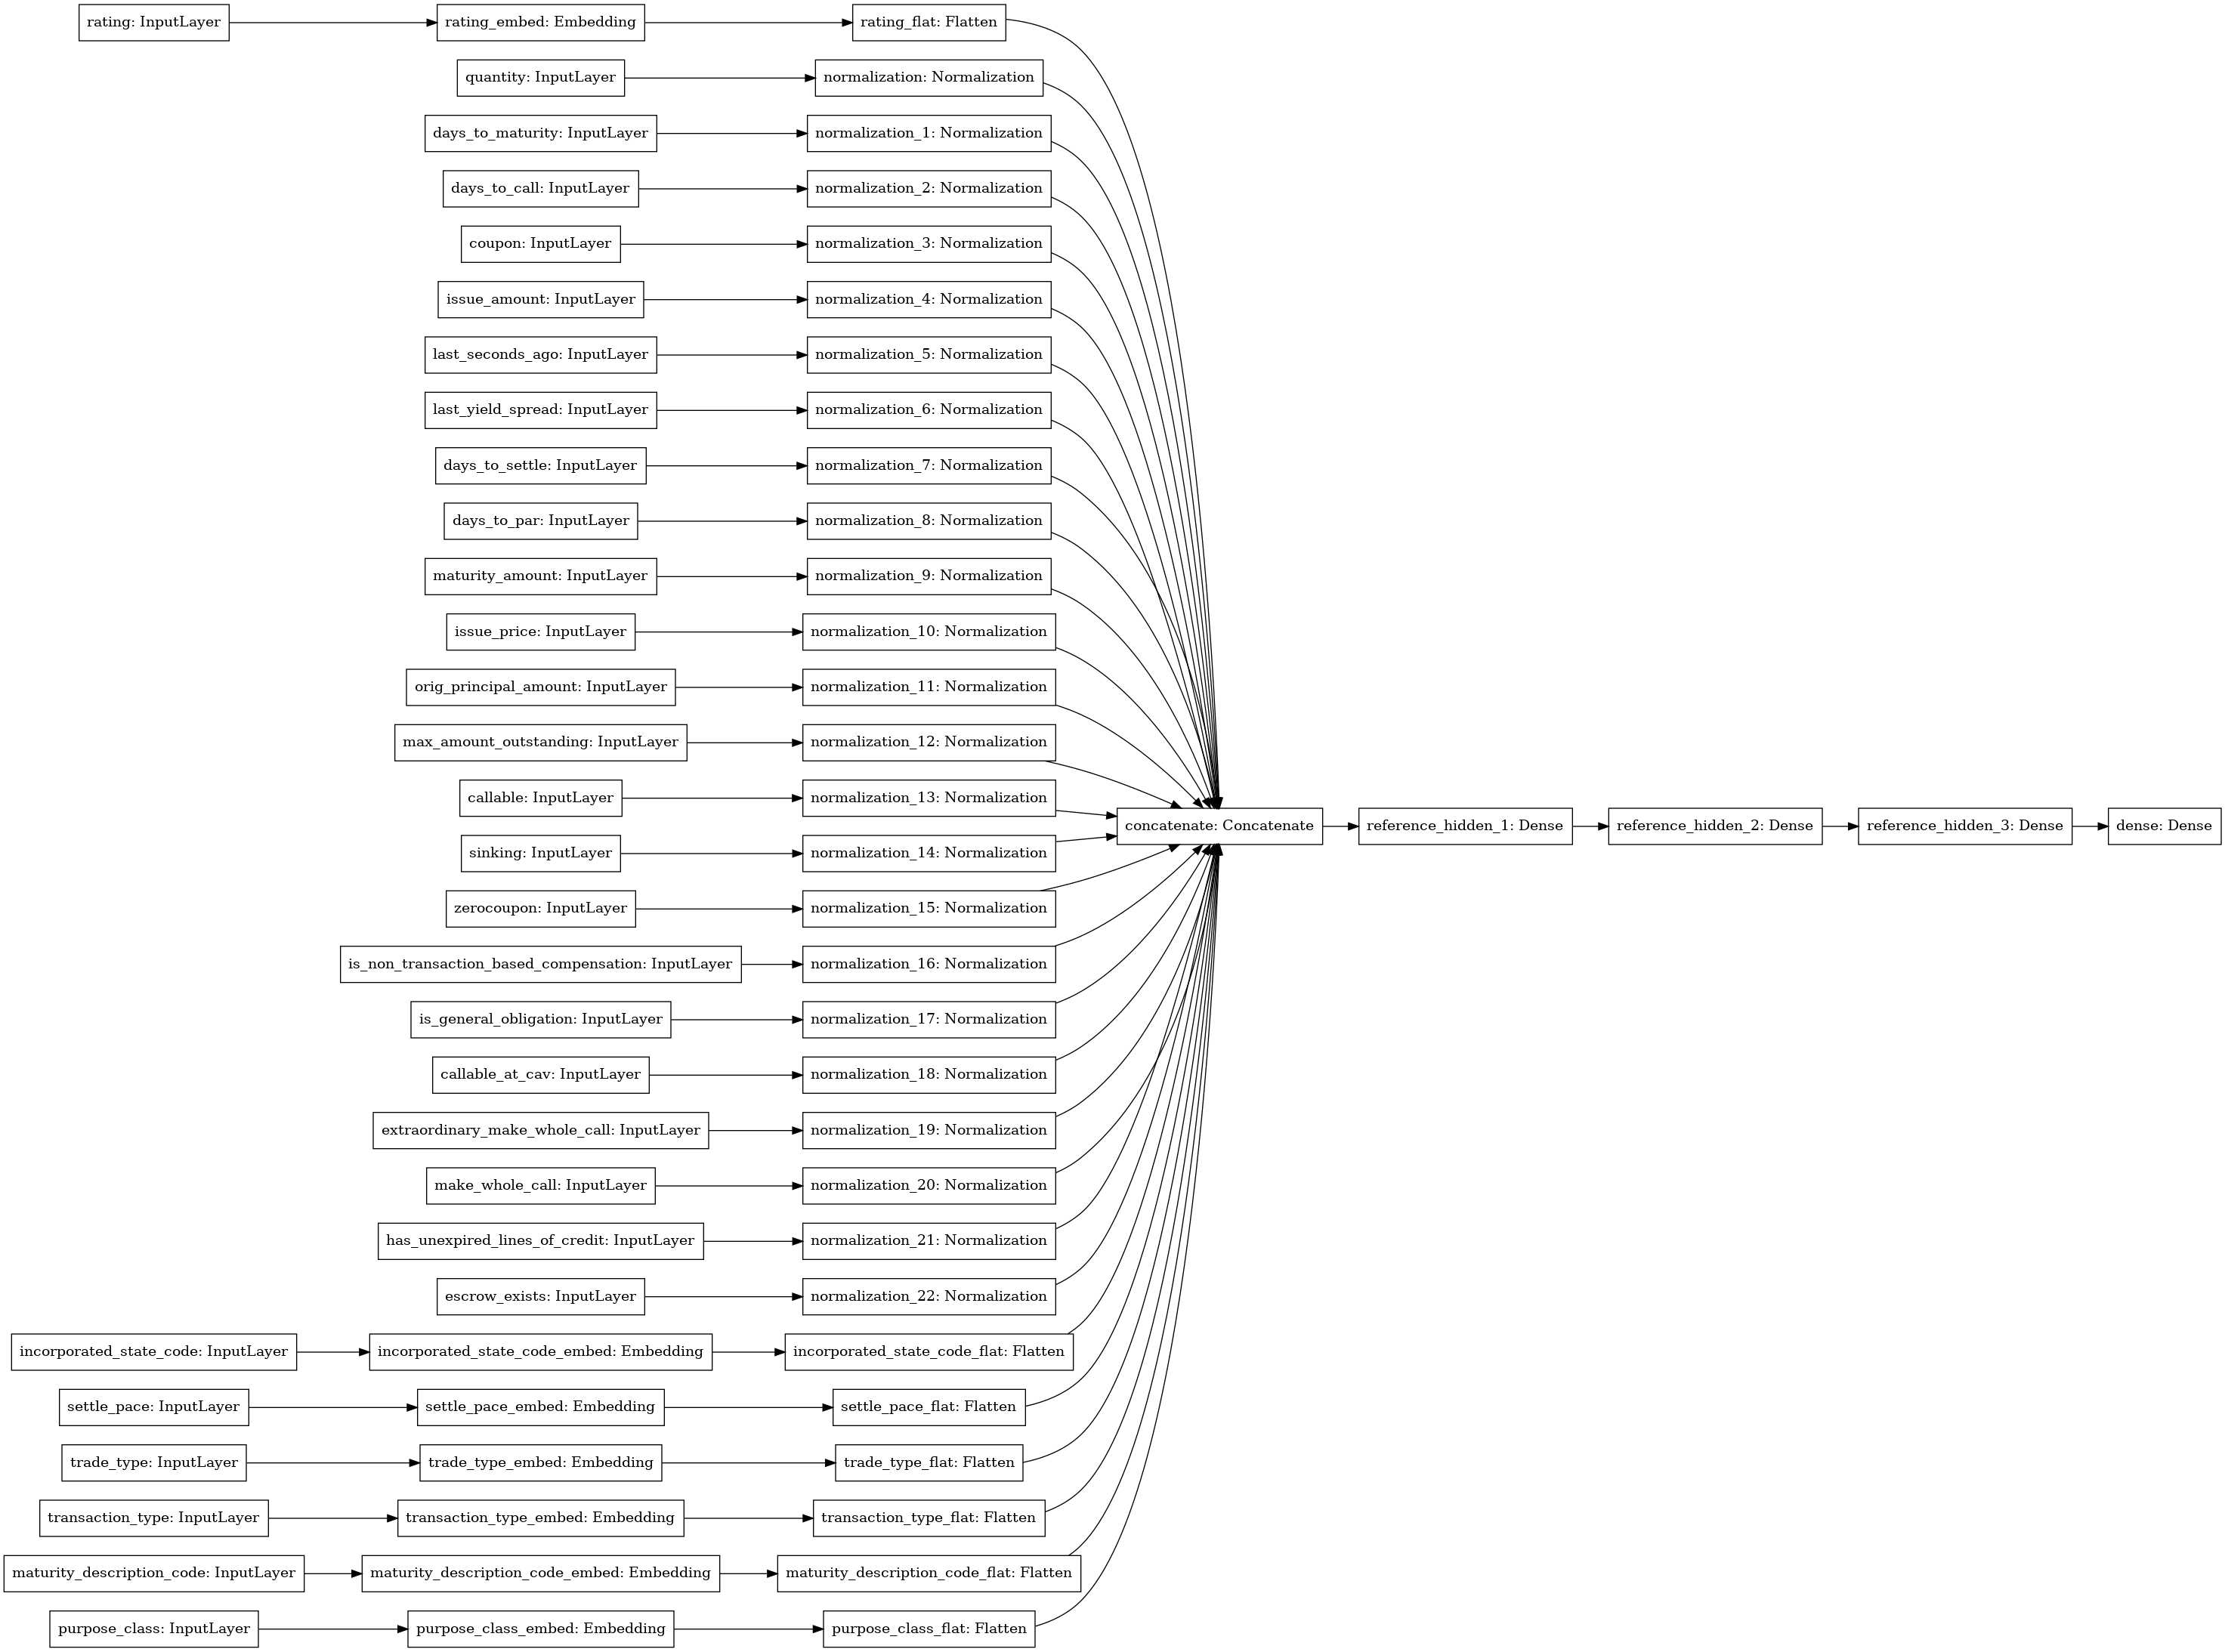

In [37]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [38]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [39]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 10,
                                                 profile_batch = '500,520')

In [40]:
train_data = create_input(train_dataframe)
%time history = model.fit(train_data, train_dataframe.yield_spread, epochs=30, batch_size=1000, verbose=1, validation_split=0.1, callbacks = [tboard_callback])

Epoch 1/30
789/789 [==============================] - 10s 8ms/step - loss: 803.4492 - mean_absolute_error: 18.2845 - val_loss: 683.2980 - val_mean_absolute_error: 18.0335
Epoch 2/30
789/789 [==============================] - 5s 6ms/step - loss: 566.6796 - mean_absolute_error: 15.7169 - val_loss: 573.7399 - val_mean_absolute_error: 16.9762
Epoch 3/30
789/789 [==============================] - 5s 6ms/step - loss: 501.3556 - mean_absolute_error: 14.6138 - val_loss: 470.4726 - val_mean_absolute_error: 14.8709
Epoch 4/30
789/789 [==============================] - 5s 6ms/step - loss: 450.9299 - mean_absolute_error: 13.8095 - val_loss: 462.9395 - val_mean_absolute_error: 14.9864
Epoch 5/30
789/789 [==============================] - 5s 6ms/step - loss: 420.2082 - mean_absolute_error: 13.3987 - val_loss: 445.6707 - val_mean_absolute_error: 14.8705
Epoch 6/30
789/789 [==============================] - 5s 6ms/step - loss: 399.0261 - mean_absolute_error: 12.9961 - val_loss: 395.5646 - val_mean_abs

In [41]:
_, mae = model.evaluate(create_input(test_dataframe), test_dataframe.yield_spread, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

4832/4832 [==============================] - 17s 3ms/step - loss: 317.0343 - mean_absolute_error: 11.0161
Test MAE: 11.016


In [42]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

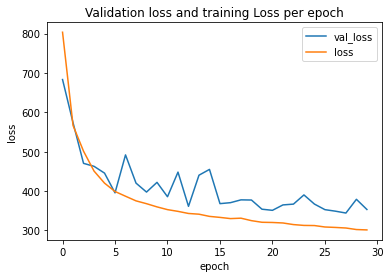

In [43]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [44]:
model.save('reference_data/')

INFO:tensorflow:Assets written to: reference_data/assets
